In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Levenshtein
import joblib
from scipy import stats

In [2]:
from pathlib import Path
import sys

main_path = str(Path().resolve().parent)
sys.path.append(main_path)

In [3]:
# carregando as funções de preprocessamento nlp do notebook de
# análise de produto, essas funções foram adicionadas nesse modulo
from src import nlp_preprocessing

In [4]:
df = pd.read_pickle("../data/train_query.pickle")
df.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
423,14710443,15837,trocador de comoda,1,3,trocador de comoda reto,moveis trocador comoda enxoval henrique,2017-08-24 15:59:44,130.50000,609.0,1,1,126,7,Bebê
11878,5013802,303463,necessaire box futebol,1,19,Necessaire box masculina personalizada Dia dos...,dia pais,2019-07-21 16:07:32,28.36000,81.0,1,8,98,15,Lembrancinhas
34479,8000979,3637678,lembrancinhas de eva para igreja,1,33,Mini Porta-retrato com mensagem Louvarei ao Se...,festividades religiosas/igreja,2018-09-08 18:38:22,12.15000,8.0,1,10,355,1,Lembrancinhas
8489,4875844,5965170,almofada para cadeira,1,0,Almofada Para Cadeira De Balanço Do Papai,almofada cadeira balanco,2018-05-13 17:55:56,169.81001,6.0,1,1,186,0,Decoração
31176,6285211,7327649,quanto custa caneca personalizada,1,0,Caneca personalizada,caneca personalizada caneca lembrancinhas mono...,2017-08-20 18:59:02,17.50000,9.0,1,4,733,0,Lembrancinhas


# Análise descritiva das queries

In [5]:
query_counts = df["query"].value_counts()
query_counts.describe()

count    5866.000000
mean        4.587794
std         6.815524
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       106.000000
Name: query, dtype: float64

In [6]:
df["position"].describe()

count    26912.000000
mean        16.906622
std         11.620276
min          0.000000
25%          6.000000
50%         16.000000
75%         27.000000
max         38.000000
Name: position, dtype: float64

Comparando com os dados de posição com os resultados da busca, vemos que
talvez tenhamos algumas inconsistências. Se até 25% das queries possuem apenas
um resultado, seria esperado que até esse mesmo percentual tivessemos resultados
de 0 posição (se o resultado é único ele também deve ser o primeiro).

Essa discrepancia pode ser originada da divisão dos dados entre treinamento e
teste. Porém, essa hipótese me parece pouco provável. O mais provável seria
que os nossos dados são apenas uma amostra dos resultados das queries agregadas.
Com isso, o fato de uma query aparecer pouco não é indicativo dela ter poucos
resultados, mas sim dela ser realizada poucas vezes.

In [7]:
query_counts.shape[0]

5866

In [8]:
(query_counts >= 10).sum()

559

In [9]:
query_with_more_results = query_counts.index[(query_counts >= 10)]
results_from_selc_queries = df["query"].isin(query_with_more_results)
results_from_selc_queries.mean()

0.41152645659928655

Com isso vemos que menos que 10% das queries possuem mais de 10 resultados.
Esse fator pode prejudicar a nossa capacidade de avaliar a recuperação de 10
resultados a partir da informação de uma query. Mas apesar de compreender uma
pequena parcela dos dados, essas queries representam mais que 40% dos dados.

Ainda assim, perder quase 60% dos resultados de query não é um resultado muito
bom.

In [10]:
# fazendo a diferença entre as distribuições das catgorias nos dados completos
# e nos dados com apenas as queries mais frequentes.
(df[results_from_selc_queries]["category"].
 value_counts(normalize=True).
 sort_index().mul(100).round(2).
 sub(df["category"].
     value_counts(normalize=True).
     sort_index().mul(100).round(2)))

Bebê                  3.21
Bijuterias e Jóias   -0.82
Decoração            -7.00
Lembrancinhas         7.65
Outros               -1.53
Papel e Cia          -1.49
Name: category, dtype: float64

Um impacto adicional é a mudança na distribuição das categorias. Essa mudança
acaba sendo mais acentuada para as categorias de lembrancinhas e decoração com
uma diferença de aproximadamente 7p.p. em cada uma. Com isso, talvez seja
interessante adicionar os dados de teste aos dados de treinamento para
aumentar a quantidade de nossos dados e com isso, talvez aumentar a proporção
total de dados que tenham queries associadas a pelo menos 10 resultados. Por
hora vamos ser conservadores e manter os datasets separados. Dependendo da
técnica de ranqueamento utilizado os dados de testes ainda podem ser úteis
para avaliar a capacidade de generalização dos sistema de recomendação.

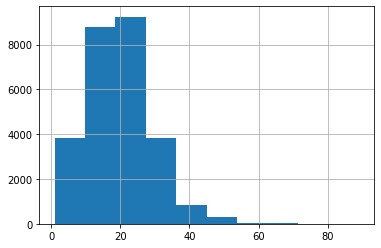

In [11]:
df["query"].apply(len).hist()
plt.show()

In [12]:
df[df["query"].apply(len) <= 2]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
35036,4587169,9485878,l,1,1,Convite L.O.L Surprise com Envelope,l.o.l surprise convites,2018-02-11 14:15:02,11.34,7.0,1,16,106,0,Papel e Cia
22539,9877776,5345324,jw,1,26,Caneca Congresso Internacional Brazil - O amor...,presentes jw congresso,2019-06-12 09:33:08,45.36,606.0,0,0,548,33,Lembrancinhas


Ao avaliar a distribuição do tamanho das queries vemos que não há grandes
problemas com as queries. Sua média é próxima de 20 e não temos nenhum registro
de query cujo tamanho seja 0, o que seria uma query vazia. Porém foram
identificados duas queries com tamanho menor ou igual a 2 que parecem que foram
erros de digitação. Para melhorar a qualidade dos dados esses registros serão
eliminados.

In [13]:
df = df.loc[~(df["query"].apply(len) <= 2)]
df[df["query"].apply(len) <= 2]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category


# Ranqueamento por distância de edição

Para obter recuperar produtos a partir de queries vamos utilizar em um primeiro
modelo de ranqueamento um modelo de distância de edição (Distância Levenshtein).
Essa é uma distância que mede um número mínimo de operações necessárias para 
transformar um string em outro.

A vantagem dessa medida de distância para o ranqueamento é que ela não depende
do treinamento de um modelo para sua execução. Dessa forma, são capazes de
ser aplicadas mesmo quando na query temos expressões completamente nova. Por
ter aplicabilidade abrangente esse método será o base para nossa comporação.

Por padrão vamos aplicar essa medida de distância sobre o título dos produtos.
Antes de fazer a comparação tanto a query quanto os títulos vão ser padronizados
utilizados as funções de pré-processamento desenvolvidas na etapa anterior.

In [14]:
def preprocess_txt(txt: str):
    cleaned_txt = nlp_preprocessing.clean_text(txt)
    token_txt = nlp_preprocessing.custom_tokenizer(cleaned_txt)
    return " ".join(token_txt)

In [15]:
def get_top_docs(query, cleaned_doc_list, doc_titles, get_titles=True):
    cleaned_query = preprocess_txt(query)
    dists = [Levenshtein.distance(cleaned_query, doc)
             for doc in cleaned_doc_list]

    mask = np.array(dists).argsort()[:10]
    if get_titles:
        return doc_titles.iloc[mask].tolist()
    else:
        return doc_titles.iloc[mask].index.tolist()

In [16]:
prod_titles = df[["product_id", "title"]].drop_duplicates().set_index("product_id")["title"]
cleaned_prod_titles = [preprocess_txt(txt) for txt in prod_titles]

In [17]:
query = "Urso de pelúcia"
get_top_docs(query, cleaned_prod_titles, prod_titles)

['Ursinhos de pelucia',
 'Tecido de Pelúcia 1,60mt x 0,50cm',
 'Ursinha Feltro',
 'Tecido de Pelúcia 1,60mt x 0,50cm',
 'URSINHOS DE TECIDOS',
 'Mini Ursinho de pelúcia',
 'Ursinho Panda',
 'Urso de crochê',
 'Colar Relicário',
 'BOLA MALUCA']

# Métrica de avaliação

Para conseguir fazer a avaliação antes precisamos estabelecer um benchmark
de comparação. O objetivo do ranqueamento é obter 10 produtos mais semelhantes
em relação à query feita. Com isso é bastante útil que tenhamos para comparar
queries com 10 resultados. Dessa forma, toda query com menos de 10 resultados
precisam ser eliminadas da comparação. Adicionalmente, as queries que tenham
mais de 10 resultados precisam ter apenas 10 selecionados.

In [18]:
def get_top_pos(df):
    position_rank = df["position"].values.argsort()[:10]
    return df["title"].iloc[position_rank].tolist()

def gen_query_results_benchmark(df):
    # remover querys com menos de 10 resultados
    query_counts = df["query"].value_counts()
    frequent_queries = query_counts.index[query_counts >= 10]
    df = df.loc[df["query"].isin(frequent_queries)]
    return df.groupby("query").apply(get_top_pos)

In [19]:
query_results = gen_query_results_benchmark(df)
query_results

query
15 anos                             [Lápis personalizado 15 anos, ALMOCHAVEIRO PER...
abajur                              [Abajur de Laço Provençal - Abajur Menina- Aba...
abridor de garrafa personalizado    [KIT COM 30 CHAV.ABRIDOR DE GARRAFA PERSONALIZ...
adega                               [Mini Adega, Adega de Vinho de Parede com Port...
adesivo box banheiro                [ADESIVO BOX DE BANHEIRO, Adesivo Para Box De ...
                                                          ...                        
vela lembrancinha                   [Lembrancinha Batizado Potinho de Vela, Lembra...
vestido batizado                    [Vestido Batizado e toalha bordada, Vestido ba...
vestido em croche para bebe         [vestido e sapatinho de croche para bebê, vest...
vingadores                          [Mochilinha Os Vingadores, Forminha Os Vingado...
xicara para cafe personalizada      [Xicara de cafe personalizada, Xícaras de café...
Length: 559, dtype: object

In [20]:
for query in ["adega", "15 anos", "xicara para cafe personalizada"]:
    assert (df.loc[df["query"] == query, ["title", "position"]].
            sort_values("position").
            head(10)["title"].tolist()) == query_results.loc[query]

In [21]:
(query_results.apply(len) == 10).all()

True

Para simplificar a comparaçao entre as duas listas, vamos ignorar a posição de
cada elemento. Vamos tratar o problema como uma comparação de dois conjuntos.
Dessa forma, estamos adotando um critério menos rigoroso do que se considerássemos
estritamente as posições. Como ambos os conjuntos possuem a mesma quantidade de
elementos podemos calcular essa métrica como sendo apenas o percentual de
registros que ambos tem como interseção.

In [22]:
def query_score(y_true, y_pred):
    inter = len(set(y_true).intersection(set(y_pred)))
        
    return inter / len(y_true)

# Avaliando o matching por distância de edição.

In [23]:
results_list = list()
for query in query_results.index:
    query_pred = get_top_docs(query, cleaned_prod_titles, prod_titles)
    query_true = query_results.loc[query]
    
    results = {
        "query": query,
        "true": query_true,
        "pred": query_pred,
        "score": query_score(query_true, query_pred),
    }
    results_list.append(results)

results_df = pd.DataFrame(results_list).set_index("query")
results_df.head()

,true,pred,score
query,,,
15 anos,"[Lápis personalizado 15 anos, ALMOCHAVEIRO PER...","[MEUS 15 ANOS, Anjo, Naninha, Naninha, Naninha...",0.0
abajur,[Abajur de Laço Provençal - Abajur Menina- Aba...,"[Abajur, Abajur, Abajur, Abajur, Flâmula, Anjo...",0.1
abridor de garrafa personalizado,[KIT COM 30 CHAV.ABRIDOR DE GARRAFA PERSONALIZ...,"[abridor de garrafa personalizado, Mini garraf...",0.2
adega,"[Mini Adega, Adega de Vinho de Parede com Port...","[ADESIVOS 5X5, ADESIVOS 3X3, Regador-P, Agenda...",0.0
adesivo box banheiro,"[ADESIVO BOX DE BANHEIRO, Adesivo Para Box De ...","[Adesivo Para Box De Banheiro 3D Seria 07, Ade...",0.2


In [24]:
results_df["score"].mean()

0.15617173524150268

# Identificando os itens e obtendo a classificação majoritária

Nessa etapa vamos reproduzir o processo necessário para gerar o resultado
final, a união entre o classificador e o sistema de recomendações. Isso quer
dizer que dada uma query, uma lista de títulos será obtida e desses, serão
identificadas a categoria majoritária. Por fim, serão printados a categoria
e os pares de id e título resultantes da recomendação.

In [25]:
# função necessária para o funcionamento do pipeline
def select_txt(X: pd.DataFrame, col: str):
    return X[col]
    
# função necessária para o funcionamento do pipeline
def select_base_features(X: pd.DataFrame):
    return X[["price", "weight", "minimum_quantity"]]

# carregando o pipeline
clf_pipeline = joblib.load("../assets/category_rf_clf_pipeline.joblib")

In [26]:
def series_mode(serie: pd.Series):
    return stats.mode(serie)[0][0]

def remove_duplicates(df, group="product_id",
                      num_cols=["price", "weight", "minimum_quantity"],
                      cat_cols=["title", "concatenated_tags"]) -> pd.DataFrame:
    
    mode_stats = {col: series_mode for col in cat_cols}
    mean_stats = {col: "mean" for col in num_cols}
    agg_stats = dict(**mode_stats, **mean_stats)
    return df.groupby(group).agg(agg_stats)

In [27]:
query = "abridor de garrafa personalizado"
prod_id_list = get_top_docs(query, cleaned_prod_titles, prod_titles, False)

selected_df = remove_duplicates(df.loc[df["product_id"].isin(prod_id_list)])
major_cat = stats.mode(clf_pipeline.predict(selected_df))[0][0]
print(major_cat)
for _id, title in selected_df["title"].iteritems():
    print(f"{_id} - {title}")

Lembrancinhas
2214077 - Abridor de garrafa - Padrinhos
2327835 - Garrafinha personalizada
3065747 - Garrafinha de 51 Personalizada
4970052 - Abridor de garrafa tampa personalizado
7767594 - abridor de garrafa personalizado
8192312 - Garrafinha Personalizada
12162214 - Garrafinha Personalizada
12873608 - Garrafinha Personalizada
13077505 - Mini garrafinha personalizada
13134048 - Garrafinhas Personalizadas
